In [17]:
# see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [18]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}
print(i2w)

vocab_size: 49
{0: 'a', 1: 'inhabit', 2: 'spells.', 3: 'direct', 4: 'evolve,', 5: 'evolution', 6: 'program.', 7: 'is', 8: 'Computational', 9: 'data.', 10: 'with', 11: 'are', 12: 'other', 13: 'People', 14: 'computer', 15: 'programs', 16: 'In', 17: 'We', 18: 'they', 19: 'by', 20: 'process', 21: 'the', 22: 'spirits', 23: 'abstract', 24: 'study', 25: 'effect,', 26: 'we', 27: 'manipulate', 28: 'process.', 29: 'that', 30: 'create', 31: 'rules', 32: 'idea', 33: 'As', 34: 'beings', 35: 'computers.', 36: 'processes.', 37: 'processes', 38: 'about', 39: 'to', 40: 'pattern', 41: 'computational', 42: 'conjure', 43: 'The', 44: 'things', 45: 'directed', 46: 'of', 47: 'our', 48: 'called'}


In [19]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset_neg_sample(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

def create_skipgram_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2]))
        data.append((text[i], text[i-1]))
        data.append((text[i], text[i+1]))
        data.append((text[i], text[i+2]))
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We')


In [20]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hidden = self.relu(self.linear1(embedded))
        out = self.linear2(hidden)
        return out

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.center_embeddings = nn.Embedding(vocab_size, embd_size)
        self.context_embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus):
        embed_centers = self.center_embeddings(focus)
        scores = torch.matmul(embed_centers, self.context_embeddings.weight.T)
        return scores

In [21]:
embd_size = 100
learning_rate = 0.001
n_epoch = 50

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.CrossEntropyLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = torch.LongTensor(ctx_idxs)

            optimizer.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, torch.LongTensor([w2i[target]]))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = []
    loss_fn = nn.CrossEntropyLoss()
    model = SkipGram(vocab_size, embd_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w in skipgram_train:
            in_w_var = torch.LongTensor([w2i[in_w]])
            out_w_var = torch.LongTensor([w2i[out_w]])
            
            optimizer.zero_grad()
            logits = model(in_w_var)
            loss = loss_fn(logits, out_w_var)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    return model, losses
    
cbow_model, cbow_losses = train_cbow()
sg_model, sg_losses = train_skipgram()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
  (relu): ReLU()
)
SkipGram(
  (center_embeddings): Embedding(49, 100)
  (context_embeddings): Embedding(49, 100)
)


In [22]:
# test
# You have to use other dataset for test, but in this case I use training data because this dataset is too small
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = torch.LongTensor(ctx_idxs)

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w in test_data:
        in_w_var = torch.LongTensor([w2i[in_w]])
        out_w_var = torch.LongTensor([w2i[out_w]])

        model.zero_grad()
        out = model(in_w_var)        

#     print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===
predicted: about
label    : about
predicted: to
label    : to
predicted: study
label    : study
predicted: the
label    : the
predicted: idea
label    : idea
predicted: of
label    : of
predicted: a
label    : a
predicted: computational
label    : computational
predicted: process.
label    : process.
predicted: Computational
label    : Computational
predicted: processes
label    : processes
predicted: are
label    : are
predicted: abstract
label    : abstract
predicted: beings
label    : beings
predicted: that
label    : that
predicted: inhabit
label    : inhabit
predicted: computers.
label    : computers.
predicted: As
label    : As
predicted: they
label    : they
predicted: evolve,
label    : evolve,
predicted: processes
label    : processes
predicted: manipulate
label    : manipulate
predicted: other
label    : other
predicted: abstract
label    : abstract
predicted: things
label    : things
predicted: called
label    : called
predicted: data.
label    : data.
predi

<Figure size 432x288 with 0 Axes>

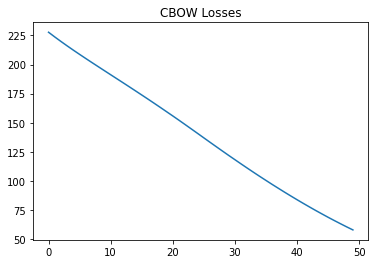

<Figure size 432x288 with 0 Axes>

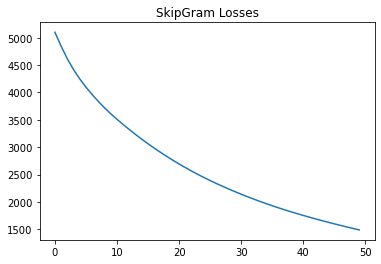

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.title(title)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')

In [24]:
embeddings = sg_model.context_embeddings.weight

In [25]:
heats = torch.matmul(embeddings, embeddings.T).detach().numpy()

In [26]:
import seaborn as sns

In [27]:
heats[0]

array([112.27067  ,  13.469541 ,  -3.424499 ,  14.038075 ,  -3.4084764,
         4.083318 , -26.53621  , -20.637413 ,  -2.0181215,   6.4402895,
       -12.821987 ,   9.586557 ,  -2.3085449,  -9.806494 ,   1.6413491,
         2.953235 , -14.827534 ,  -5.542464 ,  -9.563619 ,  21.748125 ,
         2.5772827,  -4.8627996,   6.444349 ,   2.4328525,  11.534291 ,
       -32.58055  ,  12.956515 ,  -2.1996124,  -6.5728993,  10.408502 ,
         4.382266 ,  -3.8939838,   6.467373 ,   7.618633 ,  -6.143044 ,
       -16.42108  ,   1.2369813,  -0.7790956,  12.137204 ,   4.7184   ,
       -18.850498 ,  -8.3028345,  -2.349808 ,   8.174309 ,  -8.329142 ,
         4.7673583,  11.5806055, -18.878275 ,  14.837414 ], dtype=float32)

<AxesSubplot:>

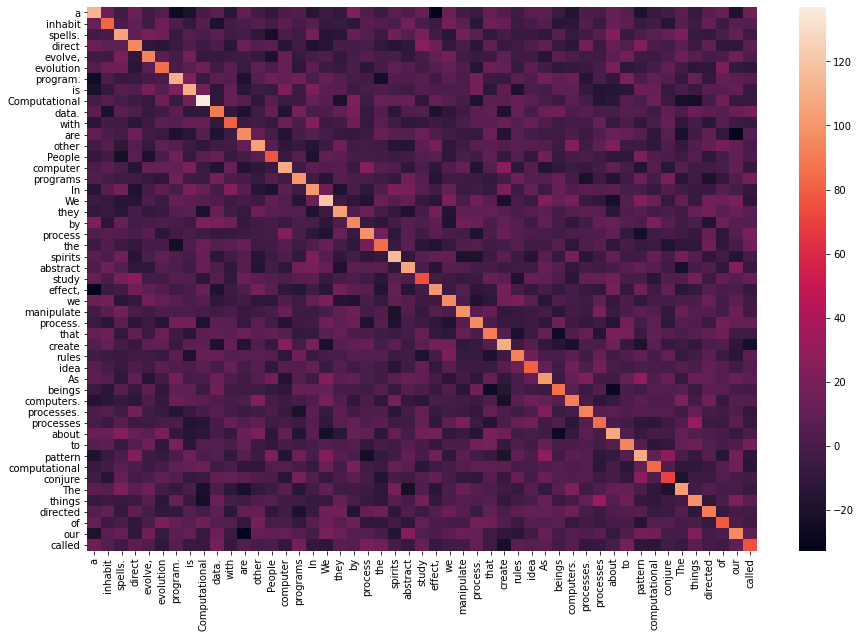

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(heats, xticklabels=[i2w[i] for i in range(len(i2w))], yticklabels=[i2w[i] for i in range(len(i2w))])

In [29]:
def nearest_neighbours(k, word):
    sims = heats[w2i[word]]
    idxs = np.argpartition(-sims,k)[:k]
    print("{} nearest neighbours for word [{}]: {}".format(
    k, word, [i2w[i] for i in idxs]))

In [30]:
nearest_neighbours(5, 'processes')

5 nearest neighbours for word [processes]: ['manipulate', 'processes', 'things', 'idea', 'rules']


In [31]:
heats[0]

array([112.27067  ,  13.469541 ,  -3.424499 ,  14.038075 ,  -3.4084764,
         4.083318 , -26.53621  , -20.637413 ,  -2.0181215,   6.4402895,
       -12.821987 ,   9.586557 ,  -2.3085449,  -9.806494 ,   1.6413491,
         2.953235 , -14.827534 ,  -5.542464 ,  -9.563619 ,  21.748125 ,
         2.5772827,  -4.8627996,   6.444349 ,   2.4328525,  11.534291 ,
       -32.58055  ,  12.956515 ,  -2.1996124,  -6.5728993,  10.408502 ,
         4.382266 ,  -3.8939838,   6.467373 ,   7.618633 ,  -6.143044 ,
       -16.42108  ,   1.2369813,  -0.7790956,  12.137204 ,   4.7184   ,
       -18.850498 ,  -8.3028345,  -2.349808 ,   8.174309 ,  -8.329142 ,
         4.7673583,  11.5806055, -18.878275 ,  14.837414 ], dtype=float32)

In [32]:
heats[w2i['processes']]

array([-7.79095590e-01, -6.62444782e+00,  5.64894342e+00, -5.81089306e+00,
       -4.15627480e+00, -2.18042850e-01,  2.92145193e-01, -1.64303455e+01,
       -1.45323715e+01, -5.27849793e-01,  1.12874765e+01,  3.55260348e+00,
        8.96219444e+00, -4.52761364e+00, -1.51027751e+00, -5.62919712e+00,
        4.88340616e+00, -1.03691330e+01,  6.08713531e+00,  1.03346195e+01,
        2.70032740e+00,  6.29688835e+00, -4.63977861e+00, -3.75534797e+00,
        9.91851139e+00, -1.03717060e+01,  9.37868118e+00,  2.06843987e+01,
       -5.00594282e+00, -1.57131357e+01,  7.16549993e-01,  1.21212454e+01,
        1.59772072e+01, -2.74214935e+00,  2.89527798e+00, -1.24280825e+01,
        5.19435453e+00,  8.49944534e+01,  5.27144670e-02, -2.07379103e+00,
       -1.20224180e+01, -1.25766993e+01, -4.54041719e+00,  2.68154907e+00,
        3.29781418e+01, -6.03439713e+00, -6.56371927e+00,  6.57449436e+00,
       -8.29389954e+00], dtype=float32)